In [48]:
!pip install --quiet kagglehub seaborn

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os

In [49]:
!pip install --quiet kagglehub

import kagglehub
import pandas as pd

print("Регрессия: Аренда велосипедов в Лондоне")
dataset = "hmavrodiev/london-bike-sharing-dataset"
path = kagglehub.dataset_download(dataset)

import glob
csv_file = glob.glob(f"{path}/*.csv")[0]
df_bikes = pd.read_csv(csv_file)

print(df_bikes.shape[0], df_bikes.shape[1])
print(df_bikes.head(), "\n")


try:
    X_train
    print("CIFAR-10 уже загружен")
except:
    print("Классификация: CIFAR-10: Картинки разных объектов")
    from tensorflow.keras.datasets import cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test  = X_test.astype('float32')  / 255.0
    y_train = y_train.flatten()
    y_test  = y_test.flatten()

print(f"   X_train: {X_train.shape}  y_train: {y_train.shape}")
print(f"   X_test : {X_test.shape}  y_test : {y_test.shape}")

Регрессия: Аренда велосипедов в Лондоне
Using Colab cache for faster access to the 'london-bike-sharing-dataset' dataset.
17414 10
             timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  
0         0.0         1.0     3.0  
1         0.0         1.0     3.0  
2         0.0         1.0     3.0  
3         0.0         1.0     3.0  
4         0.0         1.0     3.0   

CIFAR-10 уже загружен
   X_train: (50000, 32, 32, 3)  y_train: (50000,)
   X_test : (10000, 32, 32, 3)  y_test : (10000,)


In [50]:
classes, counts = np.unique(y_train, return_counts=True)

print("Баланс классов (train):")
for cls, cnt in zip(classes, counts):
    print(f"Класс {cls}: {cnt} изображений")

Баланс классов (train):
Класс 0: 5000 изображений
Класс 1: 5000 изображений
Класс 2: 5000 изображений
Класс 3: 5000 изображений
Класс 4: 5000 изображений
Класс 5: 5000 изображений
Класс 6: 5000 изображений
Класс 7: 5000 изображений
Класс 8: 5000 изображений
Класс 9: 5000 изображений


<h1>Решающие деревья (Decision Tree)</h1>

In [67]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, classification=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.classification = classification
        self.tree = None

    def _gini(self, y):
        if len(y) == 0:
            return 0.0
        counts = torch.bincount(y.long())
        probs = counts.float() / len(y)
        return 1 - torch.sum(probs ** 2)

    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        return torch.var(y.float()) * len(y)

    def _best_split(self, X, y):
        best_gain = 0.0
        best_idx = best_thr = None
        n_samples, n_features = X.shape
        parent_imp = self._gini(y) if self.classification else self._mse(y)

        for idx in range(n_features):
            values = X[:, idx]
            thresholds = torch.unique(values)

            if len(thresholds) > 20:
                step = max(1, len(thresholds) // 15)
                thresholds = thresholds[::step][:15]

            for thr in thresholds:
                left_mask  = values <= thr
                right_mask = ~left_mask

                n_left  = left_mask.sum().item()
                n_right = (len(y) - n_left)

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                if self.classification:
                    gain = parent_imp - (
                        n_left / n_samples * self._gini(y[left_mask]) +
                        n_right / n_samples * self._gini(y[right_mask])
                    )
                else:
                    gain = parent_imp - (
                        n_left / n_samples * self._mse(y[left_mask]) +
                        n_right / n_samples * self._mse(y[right_mask])
                    )

                if gain > best_gain:
                    best_gain = gain
                    best_idx = idx
                    best_thr = thr.item()

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)

        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(torch.unique(y)) == 1:

            value = torch.bincount(y.long()).argmax().item() if self.classification else y.float().mean().item()
            return {"leaf": True, "value": value}

        idx, thr = self._best_split(X, y)

        if idx is None:
            value = torch.bincount(y.long()).argmax().item() if self.classification else y.float().mean().item()
            return {"leaf": True, "value": value}

        left_mask = X[:, idx] <= thr
        left  = self._build_tree(X[left_mask],  y[left_mask],  depth + 1)
        right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)

        return {
            "leaf": False,
            "idx": int(idx),
            "thr": float(thr),
            "left": left,
            "right": right
        }

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        y = torch.tensor(y, dtype=torch.long if self.classification else torch.float32)
        self.tree = self._build_tree(X, y)

    def _predict_one(self, x, node):
        if node["leaf"]:
            return node["value"]
        if x[node["idx"]] <= node["thr"]:
            return self._predict_one(x, node["left"])
        else:
            return self._predict_one(x, node["right"])

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        preds = [self._predict_one(X[i], self.tree) for i in range(X.shape[0])]
        return torch.tensor(preds, dtype=torch.float32 if not self.classification else torch.long)

<h1>Random Forest</h1>

In [68]:
class RandomForest:
    def __init__(self, n_estimators=50, max_depth=10, max_features="sqrt", min_samples_split=2, classification=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.classification = classification
        self.trees = []

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long if self.classification else torch.float32)
        n, f = X.shape
        max_f = int(f**0.5) if self.max_features == "sqrt" else f

        self.trees = []
        for _ in range(self.n_estimators):
            idx = torch.randint(0, n, (n,))
            X_b = X[idx]
            y_b = y[idx]

            feat_idx = torch.randperm(f)[:max_f]
            X_sub = X_b[:, feat_idx]

            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, classification=self.classification)
            tree.fit(X_sub, y_b)
            tree.feat_idx = feat_idx
            self.trees.append(tree)

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        preds = []
        for tree in self.trees:
            X_sub = X[:, tree.feat_idx]
            preds.append(tree.predict(X_sub))
        preds = torch.stack(preds)

        if self.classification:
            return torch.mode(preds, dim=0).values
        else:
            return preds.float().mean(dim=0)

<h1>Градиентный бустинг</h1>

In [71]:
class GradientBoosting:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_split=2, classification=False, checkpoint_path=None,
        verbose=True):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.classification = classification

        self.checkpoint_path = checkpoint_path
        self.verbose = verbose

        self.models = []
        self.n_classes = None

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        y = torch.tensor(
            y,
            dtype=torch.long if self.classification else torch.float32
        ) if not isinstance(y, torch.Tensor) else y

        if self.classification:
            self.n_classes = len(torch.unique(y))
            self.models = []
            for cls in range(self.n_classes):
                y_bin = (y == cls).float()
                self.models.append(self._fit_single(X, y_bin, cls_id=cls))
        else:
            self.models = self._fit_single(X, y, cls_id=None)

    def _fit_single(self, X, y, cls_id=None):
        models = []
        raw_pred = torch.zeros(len(y))
        start_iter = 0

        if self.checkpoint_path and os.path.exists(self._ckpt_name(cls_id)):
          ckpt = torch.load(self._ckpt_name(cls_id), weights_only=False)
          models = ckpt["models"]
          raw_pred = ckpt["raw_pred"]
          start_iter = len(models)

          if self.verbose:
            print(f"Resume from iteration {start_iter}")

        for i in range(start_iter, self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, classification=False)
            residual = y - raw_pred
            tree.fit(X, residual)

            update = tree.predict(X)
            raw_pred += self.learning_rate * update
            models.append(tree)

            if self.verbose:
              print(f"[{i+1}/{self.n_estimators}]")

            if self.checkpoint_path:
              os.makedirs(os.path.dirname(self.checkpoint_path), exist_ok=True)
              torch.save(
                  {
                      "models": models,
                      "raw_pred": raw_pred
                  },
                  self._ckpt_name(cls_id)
              )

        return models

    def _ckpt_name(self, cls_id):
      if cls_id is None:
        return self.checkpoint_path
      return f"{self.checkpoint_path}_class_{cls_id}.pt"

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X

        if self.classification:
            scores = []
            for cls_models in self.models:
                raw_pred = torch.zeros(X.shape[0])
                for tree in cls_models:
                    raw_pred += self.learning_rate * tree.predict(X)
                scores.append(raw_pred)
            return torch.argmax(torch.stack(scores), dim=0)
        else:
            raw_pred = torch.zeros(X.shape[0])
            for tree in self.models:
                raw_pred += self.learning_rate * tree.predict(X)
            return raw_pred

<h1>Регрессия</h1>

In [75]:
df_bikes['timestamp'] = pd.to_datetime(df_bikes['timestamp'])
df_bikes['hour'] = df_bikes['timestamp'].dt.hour
df_bikes['day'] = df_bikes['timestamp'].dt.day
df_bikes['month'] = df_bikes['timestamp'].dt.month
df_bikes['weekday'] = df_bikes['timestamp'].dt.weekday

features = ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season', 'hour', 'month', 'weekday']
target = 'cnt'

df_bikes = df_bikes.sort_values('timestamp')
n = len(df_bikes)
train_df = df_bikes.iloc[:int(0.8 * n)]
test_df = df_bikes.iloc[int(0.8 * n):]

X_reg_train = train_df[features].values
y_reg_train = train_df[target].values


X_reg_test = test_df[features].values
y_reg_test = test_df[target].values

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Обучаем DecisionTree...
DecisionTree: MSE = 164789.49, MAE = 222.71
Обучаем RandomForest...
RandomForest: MSE = 663545.46, MAE = 579.21
Обучаем GradientBoosting...
[1/100]
[2/100]
[3/100]
[4/100]
[5/100]
[6/100]
[7/100]
[8/100]
[9/100]
[10/100]
[11/100]
[12/100]
[13/100]
[14/100]
[15/100]
[16/100]
[17/100]
[18/100]
[19/100]
[20/100]
[21/100]
[22/100]
[23/100]
[24/100]
[25/100]
[26/100]
[27/100]
[28/100]
[29/100]
[30/100]
[31/100]
[32/100]
[33/100]
[34/100]
[35/100]
[36/100]
[37/100]
[38/100]
[39/100]
[40/100]
[41/100]
[42/100]
[43/100]
[44/100]
[45/100]
[46/100]
[47/100]
[48/100]
[49/100]
[50/100]
[51/100]
[52/100]
[53/100]
[54/100]
[55/100]
[56/100]
[57/100]
[58/100]
[59/100]
[60/100]
[61/100]
[62/100]
[63/100]
[64/100]
[65/100]
[66/100]
[67/100]
[68/100]
[69/100]
[70/100]
[71/100]
[72/100]
[73/100]
[74/100]
[75/100]
[76/100]
[77/100]
[78/100]
[79/100]
[80/100]
[81/100]
[82/100]
[83/100]
[84/100]
[85/100]
[86/100]
[87/100]
[88/100]
[89/100]
[90/100]
[91/100]
[92/100]
[93/100]
[94/100]

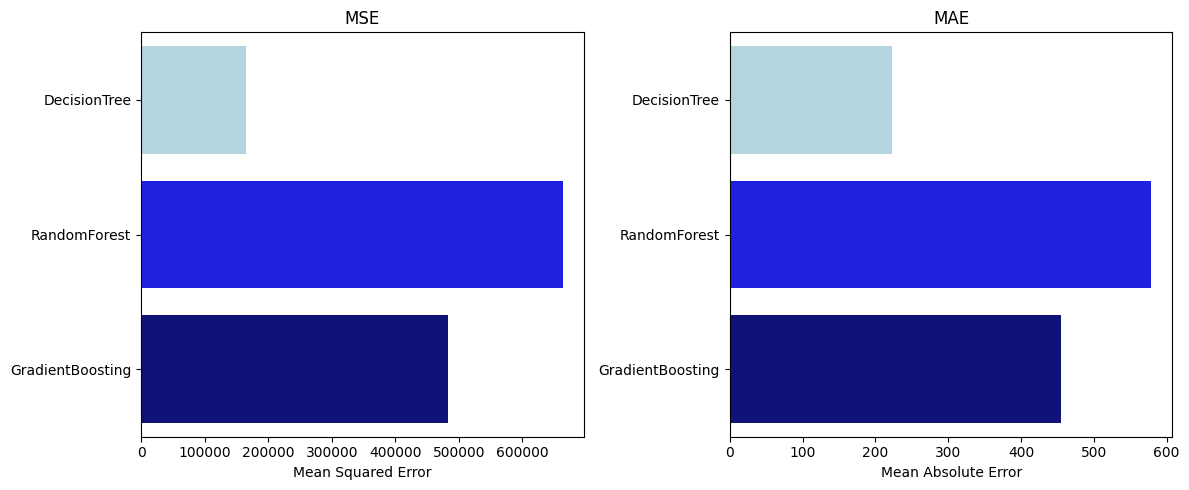

In [82]:
models_reg = {
    "DecisionTree": DecisionTree(max_depth=12, min_samples_split=3, classification=False),
    "RandomForest": RandomForest(n_estimators=70, max_depth=12, min_samples_split=3, classification=False),
    "GradientBoosting": GradientBoosting(n_estimators=100, learning_rate=0.05, max_depth=4, min_samples_split=3, classification=False, checkpoint_path="/content/drive/MyDrive/checkpoint/grad2.pt", verbose=True)
}

results_reg = {}

for name, model in models_reg.items():
    print(f"Обучаем {name}...")
    model.fit(X_reg_train, y_reg_train)
    pred = model.predict(X_reg_test)

    mse_val = mean_squared_error(y_reg_test, pred)
    mae_val = mean_absolute_error(y_reg_test, pred)
    results_reg[name] = {"MSE": mse_val, "MAE": mae_val}

    print(f"{name}: MSE = {mse_val:.2f}, MAE = {mae_val:.2f}")


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
names = list(results_reg.keys())
mse_vals = [results_reg[n]["MSE"] for n in names]
sns.barplot(
    x=mse_vals,
    y=names,
    palette=["lightblue", "blue", "darkblue"]
)
plt.title("MSE")
plt.xlabel("Mean Squared Error")

plt.subplot(1,2,2)
mae_vals = [results_reg[n]["MAE"] for n in names]
sns.barplot(
    x=mae_vals,
    y=names,
    palette=["lightblue", "blue", "darkblue"]
)
plt.title("MAE")
plt.xlabel("Mean Absolute Error")

plt.tight_layout()
plt.show()

<h1>Классификация</h1>

Количество признаков: 48
Обучаем DecisionTree...
0.2205
Обучаем RandomForest...
0.2855
Обучаем GradientBoosting...
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
Resume from iteration 10
0.25


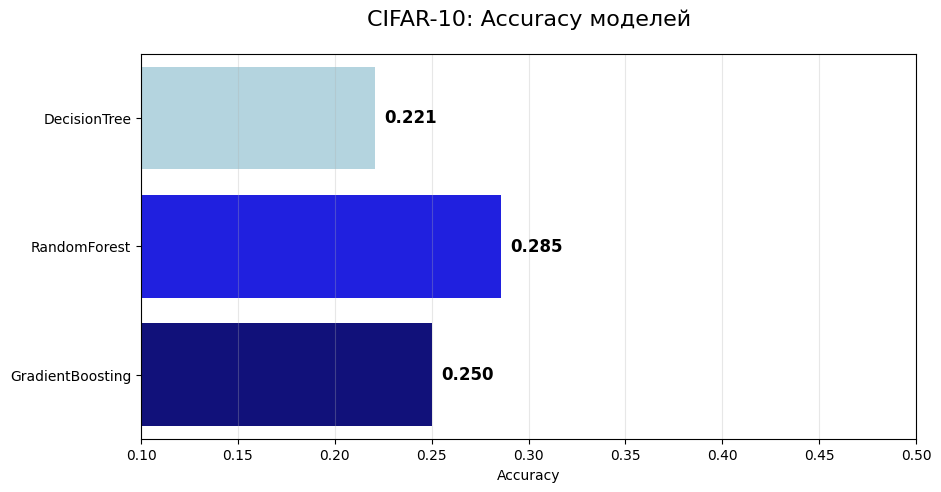

In [58]:
X_train_raw = X_train[:10000]
y_train_raw = y_train[:10000].astype(int)
X_test_raw  = X_test[:2000]
y_test_raw  = y_test[:2000].astype(int)

def extract_grid_features(X, grid=4):
    X = torch.tensor(X, dtype=torch.float32).reshape(-1, 3, 32, 32)
    h = 32 // grid
    features = []

    for i in range(grid):
        for j in range(grid):
            block = X[:, :, i*h:(i+1)*h, j*h:(j+1)*h]
            features.append(block.mean(dim=(2,3)))

    return torch.cat(features, dim=1).numpy()


X_train_flat = extract_grid_features(X_train_raw, grid=4)  # 48 признаков
X_test_flat  = extract_grid_features(X_test_raw, grid=4)

print("Количество признаков:", X_train_flat.shape[1])

models = {
    "DecisionTree": DecisionTree(max_depth=12, min_samples_split=10, classification=True),
    "RandomForest": RandomForest(n_estimators=40, max_depth=10, classification=True),
    "GradientBoosting": GradientBoosting(n_estimators=10, learning_rate=0.15, max_depth=3, classification=True, checkpoint_path="/content/drive/MyDrive/checkpoints/gb_class10.pt", verbose=True)
}

results = {}
total = len(models)

for i, (name, model) in enumerate(models.items(), 1):
    print(f"Обучаем {name}...")

    model.fit(X_train_flat, y_train_raw)

    pred = model.predict(X_test_flat)

    if torch.is_tensor(pred):
        pred = pred.numpy()
    pred = np.asarray(pred).flatten()

    acc = accuracy_score(y_test_raw, pred)

    results[name] = acc
    print(acc)


plt.figure(figsize=(10, 5))

bars = sns.barplot(
    x=list(results.values()),
    y=list(results.keys()),
    palette=["lightblue", "blue", "darkblue"]
)

plt.title("CIFAR-10: Accuracy моделей", fontsize=16, pad=20)
plt.xlabel("Accuracy")
plt.xlim(0.1, 0.5)
plt.grid(axis='x', alpha=0.3)


for i, (name, acc) in enumerate(results.items()):
    plt.text(acc + 0.005, i, f"{acc:.3f}", va='center', fontweight='bold', fontsize=12)

plt.show()